## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---

---

## Installing Hugging Face's nlp package & Importing libraries

In [8]:
%matplotlib inline

import tensorflow as tf
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def show_confusion_matrix(y_true, y_pred, classes):

    cm = confusion_matrix(y_true, y_pred, normalize='true')
    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()


print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.17.0


## Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [10]:
# Importing the Tweet Emotion dataset
df_train = pd.read_csv('datasets/training.csv')
df_test = pd.read_csv('datasets/test.csv')
df_validation = pd.read_csv('datasets/validation.csv')

In [11]:
df_train.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [20]:
df_test['text'][0]

'im feeling rather rotten so im not very ambitious right now'

In [24]:
def get_tweet(data):
    tweets = data['text']
    labels = data['label']
    return tweets, labels

In [25]:
# type of columns
df_train.dtypes

text     object
label     int64
dtype: object

In [27]:
tweets, labels = get_tweet(df_train)

In [28]:
tweets[0], labels[0]

('i didnt feel humiliated', 0)

## Task 4: Tokenizer

1. Tokenizing the tweets

In [29]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [30]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

In [31]:
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

## Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

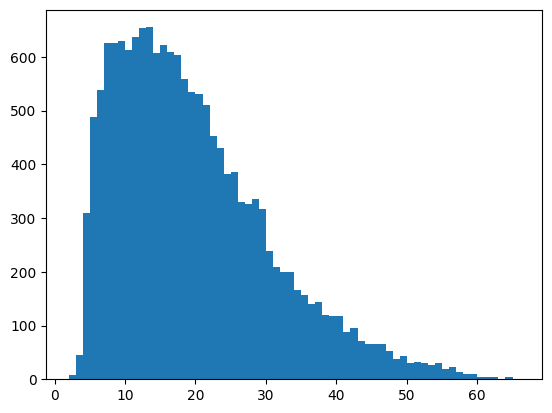

In [32]:
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins=len(set(lengths)))
plt.show()

In [34]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [37]:
maxlen = 50
def get_sequences(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded = pad_sequences(sequences, truncating='post', padding='post', maxlen=maxlen)
    return padded

In [38]:
padded_train_seq = get_sequences(tokenizer, tweets)

In [45]:
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])

(array([4666.,    0., 5362.,    0., 1304.,    0., 2159.,    0., 1937.,
           0.,  572.]),
 array([0.        , 0.45454545, 0.90909091, 1.36363636, 1.81818182,
        2.27272727, 2.72727273, 3.18181818, 3.63636364, 4.09090909,
        4.54545455, 5.        ]),
 <BarContainer object of 11 artists>)

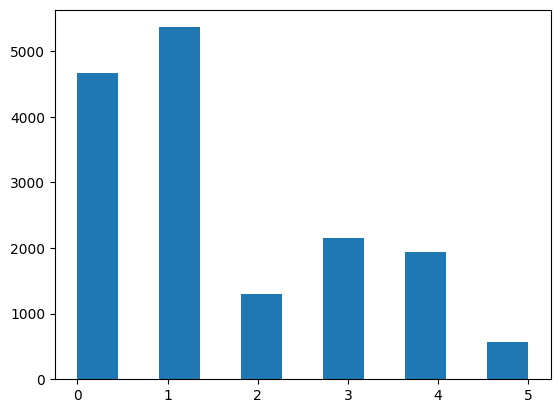

In [47]:
plt.hist(labels, bins=11)

## Creating the Model

1. Creating the model
2. Compiling the model

In [53]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=10000, output_dim=16, input_length=maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')    
])

model.build(input_shape=(None, maxlen))

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

d:\anaconda\envs\venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [54]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 50, 16)         │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 50, 40)         │         5,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 40)             │         9,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           246 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 175,926 (687.21 KB)

 Trainable params: 175,926 (687.21 KB)

 Non-trainable params: 0 (0.00 B)

## Training the Model

1. Preparing a validation set
2. Training the model

In [55]:
val_tweets, val_labels = get_tweet(df_validation)
val_seq = get_sequences(tokenizer, val_tweets)

In [56]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 0)

In [57]:
h = model.fit(
    padded_train_seq, labels,
    validation_data=(val_seq, val_labels),
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.3803 - loss: 1.5347 - val_accuracy: 0.6195 - val_loss: 0.9942
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.7148 - loss: 0.7701 - val_accuracy: 0.8190 - val_loss: 0.5520
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.8830 - loss: 0.3516 - val_accuracy: 0.8470 - val_loss: 0.4614
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9295 - loss: 0.2175 - val_accuracy: 0.8740 - val_loss: 0.4163
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9543 - loss: 0.1507 - val_accuracy: 0.8795 - val_loss: 0.3844
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9686 - loss: 0.1048 - val_accuracy: 0.8860 - val_loss: 0.3539
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9734 - loss: 0.0878 - val_accuracy: 0.8930 - val_loss: 0.3808
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9783 - loss: 0.0769 - val_a

## Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set